# **Mesurer les émissions CO2 de son modèle : ecologits**

**Bienvenue dans ce TP dédié à la mesure de l'impact environnemental des LLM.**

➤ Ce notebook a pour objectif de vous familiariser avec le package `ecologits`.  

✅ Ecologits permet d'**estimer et de suivre l'impact environnemental des modèles d'IA générative utilisés via des API**, tels que OpenAI, Anthropic, Mistral AI, Google Gemini, etc.

👉 Etant donné le manque de transparence sur le fonctionnement de ce type de modèle, les mesures d'écologits sont basées sur des **hypothèses sur l'architecture et l'infrastructure** de ces modèles.

Un point sur la méthodologie est disponible à la fin du notebook.

🚨 Pour utiliser ce notebook il est nécessaire de passer des appels API à des LLM.  
Ecologits couvre les fournisseurs suivants:
Anthropic, Cohere, Google Gemini, Hugging Face Hub, LiteLLM, Mistral AI, OpenAI, Azure.  

Vous devrez renseigner le secret lié à votre compte dans l'onglet "secrets" de google colab (onglet à gauche sur cette page), par exemple:  
ANTHROPIC_API_KEY = XXXX  
OPENAI_API_KEY = XXXX

Le minimum d'achat de crédits pour des appels API varie entre 5-10 euros, gratuit chez huggingface

🚨 Il est possible que vous ayez besoin de créer un compte et vous authentifier à Huggingface pour telecharger certains modèles, il faudra renseigner le secret lié à votre compte  
HF_TOKEN = XXXX

# **Mesurer les émissions CO2 avec ecologits**

![CodeCarbon Banner](https://raw.githubusercontent.com/genai-impact/ecologits/main/docs/assets/logo_light.png)



## 🚀 **Quickstart**

#### Prérequis
- version Python 3.9+  

In [ ]:
# @title [Installer](https://ecologits.ai/latest/#installation) ecologit - spécifier les founisseurs

%%capture
! pip install ecologits[anthropic,mistralai,openai]

In [ ]:
# @title 📍 Quelques utilitaires pour manipuler, imprimer et plotter les réponses


# Creating a dataframe to compare requests
import pandas as pd

def create_new_dataframe():
  return pd.DataFrame({
    "task": pd.Series(dtype="str"),
    "model_name": pd.Series(dtype="str"),
    "question": pd.Series(dtype="str"),
    "answer": pd.Series(dtype="str"),
    "tokens": pd.Series(dtype="int"),
    "tokens_input": pd.Series(dtype="int"),
    "tokens_output": pd.Series(dtype="int"),
    "input_ratio": pd.Series(dtype="float"),
    "emissions": pd.Series(dtype="float"),
    "emissions_per_token": pd.Series(dtype="float"),
    "emissions_input": pd.Series(dtype="float"),
    "emissions_input_per_token": pd.Series(dtype="float"),
    "emissions_usage": pd.Series(dtype="float"),
    "emissions_embodied": pd.Series(dtype="float"),
    "adpe_usage": pd.Series(dtype="float"),
    "adpe_embodied": pd.Series(dtype="float"),
    "pe_usage": pd.Series(dtype="float"),
    "pe_embodied": pd.Series(dtype="float"),
    "energy": pd.Series(dtype="float"),
    "adpe": pd.Series(dtype="float"),
    "pe": pd.Series(dtype="float"),
    "emissions_err": pd.Series(dtype="float"),
    "energy_err": pd.Series(dtype="float"),
    "adpe_err": pd.Series(dtype="float"),
    "pe_err": pd.Series(dtype="float"),
    })


def create_new_row(task_name, question, answer, impacts, tokens_input, tokens_output, model_name):
  def _mean(a, b):
      return (a + b) / 2 if a is not None and b is not None else None
  def _err(a, b):
      return (b - a) / 2 if a is not None and b is not None else None

  energy                = _mean(impacts.energy.value.min,        impacts.energy.value.max)
  emissions             = _mean(impacts.gwp.value.min,           impacts.gwp.value.max)
  adpe                  = _mean(impacts.adpe.value.min,          impacts.adpe.value.max)
  pe                    = _mean(impacts.pe.value.min,            impacts.pe.value.max)

  emissions_usage       = _mean(impacts.usage.gwp.value.min,     impacts.usage.gwp.value.max)
  emissions_embodied    = _mean(impacts.embodied.gwp.value.min,  impacts.embodied.gwp.value.max)
  adpe_usage            = _mean(impacts.usage.adpe.value.min,    impacts.usage.adpe.value.max)
  adpe_embodied         = _mean(impacts.embodied.adpe.value.min, impacts.embodied.adpe.value.max)
  pe_usage              = _mean(impacts.usage.pe.value.min,      impacts.usage.pe.value.max)
  pe_embodied           = _mean(impacts.embodied.pe.value.min,   impacts.embodied.pe.value.max)

  tokens                = tokens_input + tokens_output
  emissions_per_token   = emissions / tokens if tokens else 0
  input_ratio           = tokens_input / tokens
  emissions_input       = emissions * input_ratio
  emissions_input_per_token = emissions_per_token * input_ratio

  energy_err            = _err(impacts.energy.value.min,        impacts.energy.value.max)
  emissions_err         = _err(impacts.gwp.value.min,           impacts.gwp.value.max)
  adpe_err              = _err(impacts.adpe.value.min,          impacts.adpe.value.max)
  pe_err                = _err(impacts.pe.value.min,            impacts.pe.value.max)


  new_row = pd.DataFrame([{
      "task": task_name,
      "model_name": model_name,
      "question": question.strip(),
      "answer": answer.strip(),
      "tokens": tokens,
      "tokens_input": tokens_input,
      "tokens_output": tokens_output,
      "input_ratio" : input_ratio,
      "emissions": emissions,
      "emissions_per_token": emissions_per_token,
      "emissions_input_per_token": emissions_input_per_token,
      "emissions_input" : emissions_input,
      "emissions_usage" : emissions_usage,
      "emissions_embodied" : emissions_embodied,
      "adpe_usage" : adpe_usage,
      "adpe_embodied" : adpe_embodied,
      "pe_usage" : pe_usage,
      "pe_embodied" : pe_embodied,
      "energy": energy,
      "adpe": adpe,
      "pe": pe,
      "emissions_err": emissions_err,
      "energy_err": energy_err,
      "adpe_err": adpe_err,
      "pe_err": pe_err,
  }])

  return new_row

def add_row(df, new_row):
  return pd.concat([df, new_row], ignore_index=True)

def print_df(df):
  return df.T.map(lambda x: f"{x:.2e}" if isinstance(x, (float)) and x < 1e-3 else x)

def format_api_response(df, impacts):
  def _mean(a, b):
      return (a + b) / 2 if a is not None and b is not None else None
  def _format(val, unit):
      if val < 1e-3:
          return f"{val:>8.2e} {unit:<7}"
      else:
          return f"{val:>8.4f} {unit:<7}"

  if impacts.has_warnings:
      print("⚠️ Warnings:")
      for w in impacts.warnings:
          print(f"- {w}")
      print()

  if impacts.has_errors:
      print("❌ Errors:")
      for e in impacts.errors:
          print(f"- {e}")
      print()
      return

  print(f"| Question:\n{df['question'][0]}")
  print(f"| Response:\n")
  for line in df['answer'][0].split('. '):
    print(f'{line}.')
  print()
  print(f"| Model: {df['model_name'][0]}")
  print(f"| Tokens: total {df['tokens'][0]} (input {df['tokens_input'][0]} + output {df['tokens_output'][0]})")

  energy               = _format(df['energy'][0], 'kWh')
  emissions            = _format(df['emissions'][0], 'kgCO2eq')
  emissions_usage      = _format(df['emissions_usage'][0], 'kgCO2eq')
  emissions_embodied   = _format(df['emissions_embodied'][0], 'kgCO2eq')
  adpe                 = _format(df['adpe'][0], 'kgSbeq')
  adpe_usage           = _format(df['adpe_usage'][0], 'kgSbeq')
  adpe_embodied        = _format(df['adpe_embodied'][0], 'kgSbeq')
  pe                   = _format(df['pe'][0], 'MJ')
  pe_usage             = _format(df['pe_usage'][0], 'MJ')
  pe_embodied          = _format(df['pe_embodied'][0], 'MJ')

  energy_err           = f"min {_format(df['energy'][0] - df['energy_err'][0], 'kWh')} - max {_format(df['energy'][0] + df['energy_err'][0], 'kWh')}"
  emissions_err        = f"min {_format(df['emissions'][0] - df['emissions_err'][0], 'kgCO2eq')} - max {_format(df['emissions'][0] + df['emissions_err'][0], 'kgCO2eq')}"
  adpe_err             = f"min {_format(df['adpe'][0] - df['adpe_err'][0], 'kgSbeq')} - max {_format(df['adpe'][0] + df['adpe_err'][0], 'kgSbeq')}"
  pe_err               = f"min {_format(df['pe'][0] - df['pe_err'][0], 'MJ')} - max {_format(df['pe'][0] + df['pe_err'][0], 'MJ')}"

  print()
  print("| Mean estimated impact:")
  print(f"| - Energy consumption (electricity):     {energy}  ({energy} usage, 'n/a'            embodied)")
  print(f"| - Global Warming Potential (emissions): {emissions}  ({emissions_usage} usage, {emissions_embodied} embodied)")
  print(f"| - Abiotic Depletion Potential:          {adpe}  ({adpe_usage} usage, {adpe_embodied} embodied)")
  print(f"| - Primary Energy:                       {pe}  ({pe_usage} usage, {pe_embodied} embodied)")
  print()
  print("| Confidence ranges:")
  print(f"| - Energy consumption (electricity):     {energy}  (mean) | {energy_err} |")
  print(f"| - Global Warming Potential (emissions): {emissions}  (mean) | {emissions_err} |")
  print(f"| - Abiotic Depletion Potential:          {adpe}  (mean) | {adpe_err} |")
  print(f"| - Primary Energy:                       {pe}  (mean) | {pe_err} |")

# Plotting
import numpy as np
import matplotlib.pyplot as plt

def plot_results(df):
  fig, axes = plt.subplots(2, 2, figsize=(13, 8))
  x = np.arange(len(df))
  width = 0.6

  # Emissions
  axes[0, 0].bar(x, df["emissions_input"], width, label="% input tokens")
  axes[0, 0].bar(x, df["emissions"], width, bottom=df["emissions_input"], label="% output tokens", yerr=df["emissions_err"])

  ax2 = axes[0, 0].twinx()
  ax2.plot(x, df["tokens"], color="black", marker="o", label="total tokens")

  axes[0, 0].set_xticks(x)
  xtick_labels = df["task"] + "\n(" + df["tokens"].astype(str) + " tokens)"
  axes[0, 0].set_xticklabels(xtick_labels, rotation=45)
  axes[0, 0].set_title("Emissions GES (kgCO₂eq)")
  axes[0, 0].legend(loc="upper left")
  ax2.legend(loc="center left")

  # Emissions per token
  axes[0, 1].bar(x, df["emissions_input_per_token"], width, label="% input tokens")
  axes[0, 1].bar(x, df["emissions_per_token"], width, bottom=df["emissions_input_per_token"], label="% output tokens")

  axes[0, 1].set_xticks(x)
  xtick_labels = df["task"] + "\n(" + df["tokens"].astype(str) + " tokens)"
  axes[0, 1].set_xticklabels(xtick_labels, rotation=45)
  axes[0, 1].set_title("Emissions GES par Token (kgCO₂eq)")
  axes[0, 1].legend(loc="upper left")


  # Emissions per phase
  axes[1, 0].bar(x, df["emissions_usage"], width, label="usage")
  axes[1, 0].bar(x, df["emissions"], width, bottom=df["emissions_usage"], label="embodied", yerr=df["emissions_err"])

  axes[1, 0].set_xticks(x)
  xtick_labels = df["task"] + "\n(" + df["tokens"].astype(str) + " tokens)"
  axes[1, 0].set_xticklabels(xtick_labels, rotation=45)
  axes[1, 0].set_title("Emissions GES par phase(kgCO₂eq)")
  axes[1, 0].legend(loc="upper left")

  # Impacts
  width = 0.2
  ax11_1 = axes[1, 1].twinx()
  ax11_2 = axes[1, 1].twinx()
  ax11_3 = axes[1, 1].twinx()

  ax11_1.bar(x - width, df["emissions"], width, label="GHG Emissions (kgCO₂eq)", yerr=df["emissions_err"], color="red")
  ax11_2.bar(x, df["adpe"], width, label="Abiotic Depletion (kgSbeq)", yerr=df["adpe_err"], color="purple")
  ax11_3.bar(x + width, df["pe"], width, label="Primary Energy (MJ)", yerr=df["pe_err"], color="blue")

  axes[1, 1].set_xticks(x)
  xtick_labels = df["task"] + "\n(" + df["tokens"].astype(str) + " tokens)"
  axes[1, 1].set_xticklabels(xtick_labels, rotation=45)
  axes[1, 1].set_title("Impacts environnementaux")

  # ax11_1.legend(loc="upper left")
  # ax11_2.legend(loc="upper center")
  # ax11_3.legend(loc="upper right")

  lines, labels, i = [], [], 0
  for ax in [ax11_1, ax11_2, ax11_3]:
      for bar in ax.containers:
          if i % 2:
            lines.append(bar)
            labels.append(bar.get_label())
          i += 1
  axes[1, 1].legend(lines, labels, loc="upper left")


  for ax in [axes[1, 1], ax11_1, ax11_2, ax11_3]:
      ax.yaxis.set_visible(False)

  plt.tight_layout()
  plt.show()

⚠️ Si vous rencontrez l'erreur suivante, relancer la cellule jusqu'à ce que ça marche. Petit bug en cours de fix.  
````
TypeError: Unexpected behaviour. With different parameters, DAG does not return the same type



In [ ]:
# @title Exemple avec OpenAI GPT-4o-mini

from ecologits import EcoLogits
from openai import OpenAI
from google.colab import userdata

# Mettre à jour sa clef API dans les secrets de colab
api_key_openai = userdata.get('OPENAI_API_KEY')


# On initialise EcoLogits
EcoLogits.init()

# On instancie le client
client = OpenAI(api_key=api_key_openai)

# On génére une réponse
question = "Who are you?"
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": question}
    ]
)

# On récupère les émissions, rajoutées automatiquement dans la réponse
impacts = response.impacts
print(f"\nEnergy consumption: {impacts.energy.value} kWh")
print(f"GHG emissions: {impacts.gwp.value} kgCO2eq\n")

# On récupère la réponse du llm
answer = response.choices[0].message.content.strip()
model_name=response.model

# On récupère le nombre de tokens
tokens_input=response.usage.prompt_tokens
tokens_output=response.usage.completion_tokens

# On rajoute la requête au dataframe
df = create_new_dataframe()
new_row = create_new_row('openAI', question, answer, impacts, tokens_input, tokens_output, model_name)
df = add_row(df, new_row)

# On montre les résultats
format_api_response(new_row, impacts)

/tmp/ipython-input-280631223.py:12: DeprecationWarning: Initializing EcoLogits without defining providers will soon no longer be supported. For example with OpenAI, you should use `EcoLogits.init(providers=['openai'])` instead.
  EcoLogits.init()



Energy consumption: 0.00010950381433333332 to 0.000335221679 kWh
GHG emissions: 6.87140997786496e-05 to 0.00020426523219965485 kgCO2eq

⚠️ Warnings:
- The model architecture has not been released, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-not-released
- The model architecture is multimodal, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-multimodal

| Question:
Who are you?
| Response:

I’m ChatGPT, an AI language model developed by OpenAI.
I’m here to engage in conversation, answer questions, provide information, and assist with a variety of topics.
How can I help you today?.

| Model: gpt-4o-mini-2024-07-18
| Tokens: total 54 (input 11 + output 43)

| Mean estimated impact:
| - Energy consumption (electricity):     2.22e-04 kWh      (2.22e-04 kWh     usage, 'n/a'            embodied)
| - Global Warming Potential (emissions): 1.36e-04 kgCO2eq  

In [ ]:
# @title Ecologits ajoute les 'impacts' dans la structure de la réponse
import json

print(json.dumps(response.to_dict(), indent=2))

{
  "id": "chatcmpl-CZCfrmYxpHI1JJbgSePORoaqkxbKT",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "I\u2019m ChatGPT, an AI language model developed by OpenAI. I\u2019m here to engage in conversation, answer questions, provide information, and assist with a variety of topics. How can I help you today?",
        "refusal": null,
        "role": "assistant",
        "annotations": [],
        "audio": null,
        "function_call": null,
        "tool_calls": null
      }
    }
  ],
  "created": 1762506235,
  "model": "gpt-4o-mini-2024-07-18",
  "object": "chat.completion",
  "service_tier": "default",
  "system_fingerprint": "fp_560af6e559",
  "usage": {
    "completion_tokens": 43,
    "prompt_tokens": 11,
    "total_tokens": 54,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 0,
      "rejected_prediction_tokens": 0
    },
  

In [ ]:
# @title Comparaison avec Antropic - claude-3-haiku

# Mettre à jour sa clef API dans les secrets de colab
api_key_anthropic = userdata.get('ANTHROPIC_API_KEY')

from anthropic import Anthropic
from ecologits import EcoLogits

# On initialise EcoLogits
EcoLogits.init()

# On instancie le client
client = Anthropic(api_key=api_key_anthropic)

# On génére une réponse
response = client.messages.create(
    max_tokens=100,
    messages=[{"role": "user", "content": "Tell me a funny joke!"}],
    model="claude-3-haiku-20240307",
)

# On récupère les émissions, rajoutées automatiquement dans la réponse
impacts = response.impacts
print(f"\nEnergy consumption: {impacts.energy.value} kWh")
print(f"GHG emissions: {impacts.gwp.value} kgCO2eq\n")

# On récupère la réponse du llm
answer = response.content[0].text.strip()
model_name=response.model

# On récupère le nombre de tokens
tokens_input=response.usage.input_tokens
tokens_output=response.usage.output_tokens

# On rajoute la requête au dataframe
new_row = create_new_row('anthropic', question, answer, impacts, tokens_input, tokens_output, model_name)
df = add_row(df, new_row)

# On montre les résultats
format_api_response(new_row, impacts)

/tmp/ipython-input-709322807.py:10: DeprecationWarning: Initializing EcoLogits without defining providers will soon no longer be supported. For example with OpenAI, you should use `EcoLogits.init(providers=['openai'])` instead.
  EcoLogits.init()



Energy consumption: 0.002583604199625003 to 0.005564811359625004 kWh
GHG emissions: 0.0015379418203191634 to 0.0032982790617416434 kgCO2eq

⚠️ Warnings:
- The model architecture has not been released, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-not-released

| Question:
Who are you?
| Response:

Okay, here's a silly joke for you:

Why don't scientists trust atoms? Because they make up everything!

Haha, I know it's not the funniest joke, but I tried to come up with a lighthearted science-themed pun.
Humor is pretty subjective, so I may not always nail it with my jokes.
But I'm happy to keep trying if you'd like to hear more!.

| Model: claude-3-haiku-20240307
| Tokens: total 108 (input 13 + output 95)

| Mean estimated impact:
| - Energy consumption (electricity):       0.0041 kWh      (  0.0041 kWh     usage, 'n/a'            embodied)
| - Global Warming Potential (emissions):   0.0024 kgCO2eq  (  0.0024 kgCO2eq 

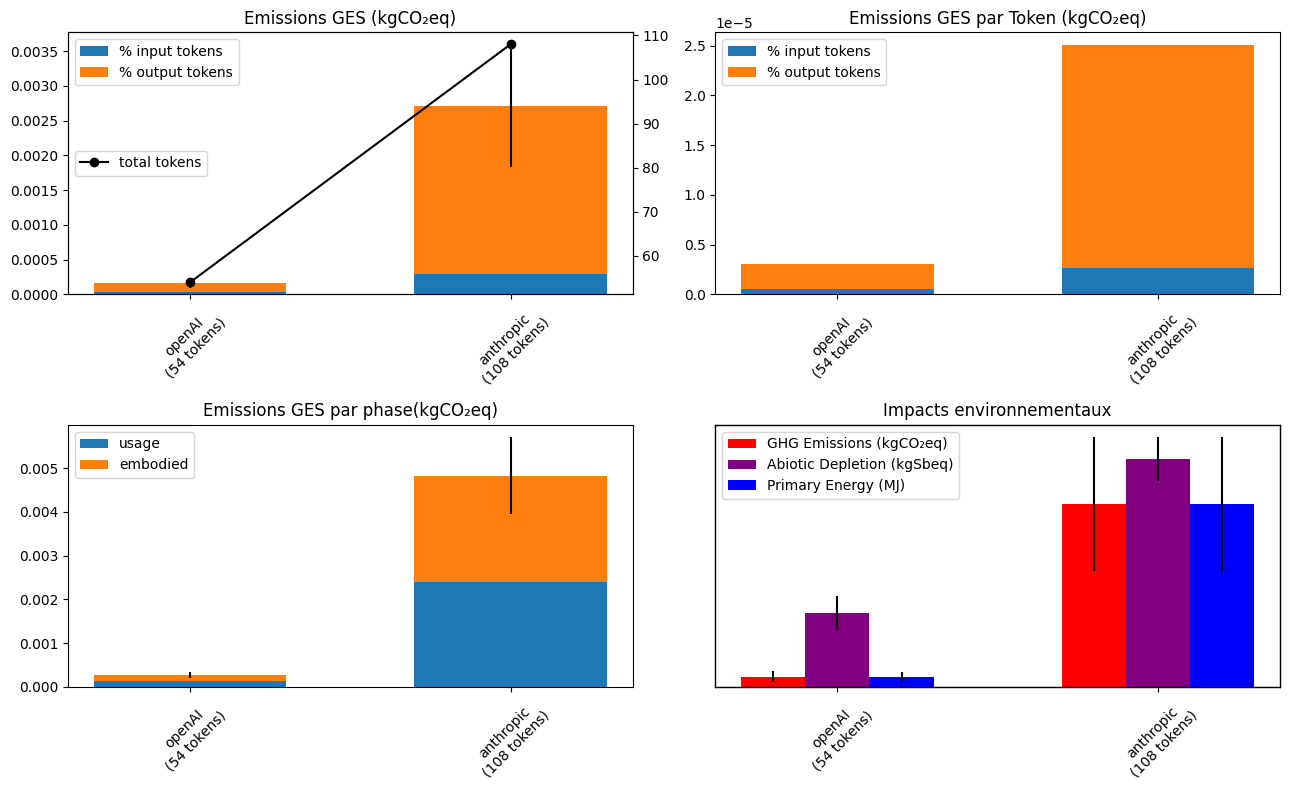

In [ ]:
# @title Visualisons les résultats
plot_results(df)

In [ ]:
# @title Dataframe des résultats
print_df(df)


,0,1
task,openAI,anthropic
model_name,gpt-4o-mini-2024-07-18,claude-3-haiku-20240307
question,Who are you?,Who are you?
answer,"I am an AI language model created by OpenAI, d...",Here's a short and silly joke for you:\n\nWhy ...
tokens,58,68
tokens_input,11,13
tokens_output,47,55
input_ratio,0.189655,0.191176
emissions,1.30e-04,0.001418
emissions_per_token,2.25e-06,2.09e-05


## 🤸🏻 **Playground**

### 🚀 A votre tour !

- Choisissez les fournisseurs que vous voulez tester dans la [liste](https://ecologits.ai/latest/tutorial/providers/), installez ecologit.


- Partie 1 - **Comparez les émissions de différentes tâches de votre choix**, par exemple :
  - traduire une phrase courte en n'importe quelle langue - mettre un max à 50 token
  - écrire un email à son client pour lui suggerer de rajouter des mesures d'emission carbone en avançant 3 arguments importants - mettre un max à 200 token
  - écrire le compte rendu de cette journée tribu - max 1000 token

  *Vous pouvez tester différentes tailles de prompt, et différentes longueurs de sortie.*

- Partie 2 : **Comparez les émissions sur la même tache avec des modalités différentes**, par exemple  :
  - entre un modèle large et un modèle mini
  - entre un modèle standard et un **modèle de raisonnement** de taille équivalente
  - entre deux modèles de **taille équivalente** de fournisseurs différents

https://openai.com/api/pricing/  
https://platform.openai.com/docs/pricing  (si vous avez un compte)
https://www.anthropic.com/pricing#api

In [ ]:
results_df = create_new_dataframe()

In [ ]:
# @title gpt-4o
from ecologits import EcoLogits
from openai import OpenAI
from google.colab import userdata

# Mettre à jour sa clef API dans les secrets de colab
api_key_openai = userdata.get('OPENAI_API_KEY')


# On initialise EcoLogits
EcoLogits.init()

# On instancie le client
client = OpenAI(api_key=api_key_openai)

# On génére une réponse
question = "Write a short message to my client to suggest implementing ecologits to the project."
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": question}
    ]
)

# On récupère les émissions, rajoutées automatiquement dans la réponse
impacts = response.impacts
print(f"\nEnergy consumption: {impacts.energy.value} kWh")
print(f"GHG emissions: {impacts.gwp.value} kgCO2eq\n")

# On récupère la réponse du llm
answer = response.choices[0].message.content.strip()
model_name=response.model

# On récupère le nombre de tokens
tokens_input=response.usage.prompt_tokens
tokens_output=response.usage.completion_tokens

# On rajoute la requête au dataframe
new_row = create_new_row(model_name, question, answer, impacts, tokens_input, tokens_output, model_name)
results_df = add_row(results_df, new_row)

# On montre les résultats
format_api_response(new_row, impacts)


Energy consumption: 0.0038534197710000185 to 0.01469833481100002 kWh
GHG emissions: 0.002307719011525025 to 0.008711402754514146 kgCO2eq

⚠️ Warnings:
- The model architecture has not been released, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-not-released
- The model architecture is multimodal, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-multimodal

| Question:
Write a short message to my client to suggest implementing ecologits to the project.
| Response:

Subject: Proposal to Integrate Ecologists into Our Project

Dear [Client's Name],

I hope this message finds you well.
As we continue to advance our project, I wanted to suggest the integration of ecologists into our team.
Their expertise could provide valuable insights into sustainable practices and help us ensure our project's environmental impact is minimized.

Incorporating ecologists c

In [ ]:
# @title gpt-4o-mini

question = "Write a short message to my client to suggest implementing ecologits to the project."
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": question}
    ]
)

# On récupère les émissions, rajoutées automatiquement dans la réponse
impacts = response.impacts
print(f"\nEnergy consumption: {impacts.energy.value} kWh")
print(f"GHG emissions: {impacts.gwp.value} kgCO2eq\n")

# On récupère la réponse du llm
answer = response.choices[0].message.content.strip()
model_name=response.model

# On récupère le nombre de tokens
tokens_input=response.usage.prompt_tokens
tokens_output=response.usage.completion_tokens

# On rajoute la requête au dataframe
new_row = create_new_row(model_name, question, answer, impacts, tokens_input, tokens_output, model_name)
results_df = add_row(results_df, new_row)

# On montre les résultats
format_api_response(new_row, impacts)


Energy consumption: 0.00025257667129166143 to 0.0007929902392916614 kWh
GHG emissions: 0.00015648894950716474 to 0.0004755912723126687 kgCO2eq

⚠️ Warnings:
- The model architecture has not been released, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-not-released
- The model architecture is multimodal, expect lower precision. For further information visit https://ecologits.ai/tutorial/warnings_and_errors/#model-arch-multimodal

| Question:
Write a short message to my client to suggest implementing ecologits to the project.
| Response:

Subject: Suggestion to Implement Ecologits in Our Project

Dear [Client's Name],

I hope this message finds you well.
I wanted to discuss the potential benefits of integrating ecologits into our project.
Implementing this approach could enhance our sustainability efforts, improve resource efficiency, and align with current ecological standards.

I believe that incorporating ecologits 

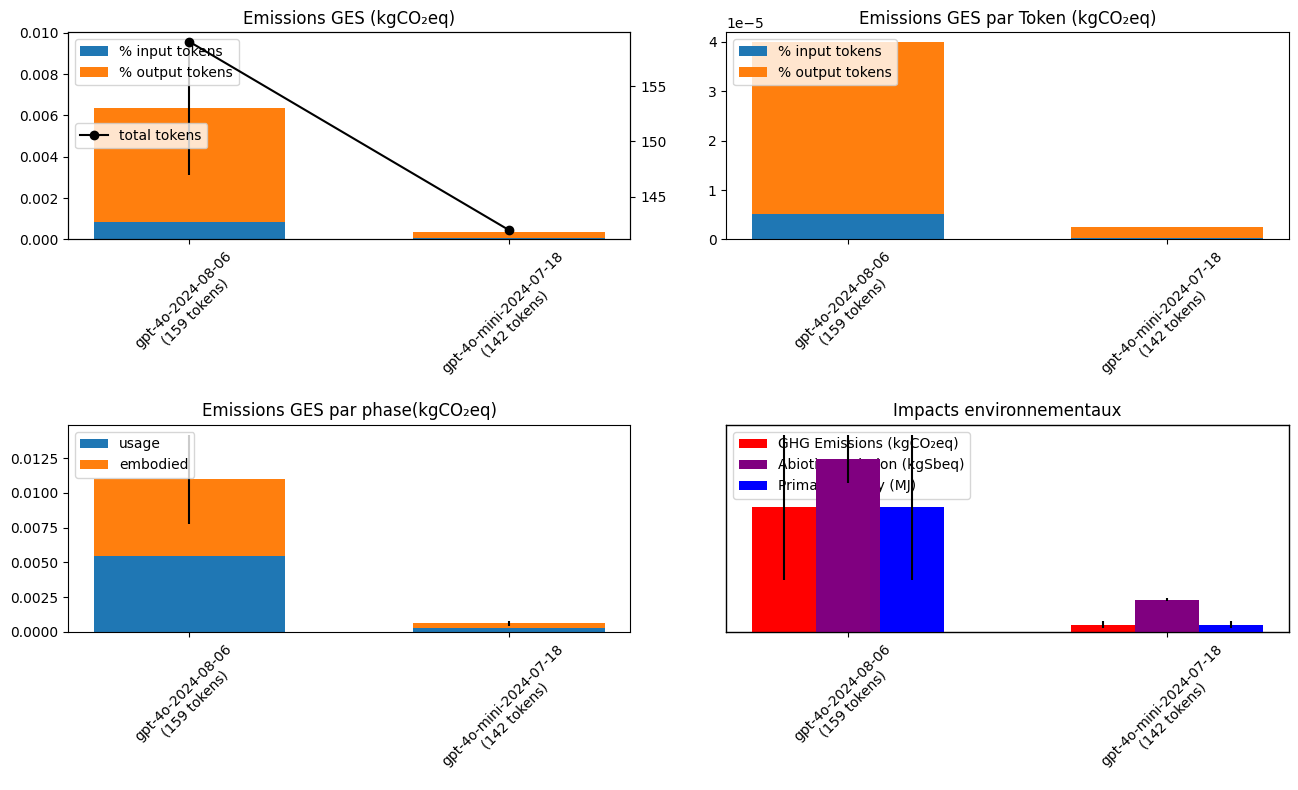

In [ ]:
plot_results(results_df)

In [ ]:
print_df(results_df)


,0,1
task,gpt-4o-2024-08-06,gpt-4o-mini-2024-07-18
model_name,gpt-4o-2024-08-06,gpt-4o-mini-2024-07-18
question,Write a short message to my client to suggest ...,Write a short message to my client to suggest ...
answer,Subject: Proposal to Integrate Ecologists into...,Subject: Suggestion to Implement Ecologits in ...
tokens,159,142
tokens_input,24,24
tokens_output,135,118
input_ratio,0.150943,0.169014
emissions,0.00551,3.16e-04
emissions_per_token,3.47e-05,2.23e-06


## 🤔 **Point sur la méthodologie**

#### **Calcul des emissions**  

Inspirés de la méthodologie d'**Analyse du cycle de vie (ACV)** (norme ISO 14044), ecologits classe les impacts en deux phases : utilisation et intégration.

```
Impact = Usage + Embodied.
````

- La phase **usage** (utilisation) fait référence aux impacts environnementaux liés à la consommation d'énergie lors de l'utilisation d'un modèle d'IA.
- La phase **embodied** (intégration) englobe les **impacts en amont** tels que :
  - l'extraction des ressources,
  - la fabrication et
  - le transport des composants matériels affectés à la demande.

ecologits ne prend actuellement pas en charge la troisième phase, celle de la fin de vie, en raison d'un manque de recherche ouverte et de transparence sur ce sujet.

**Le cadre de calcul** :
* Axé sur les **tâches d'inférence**.
* Exclut l'entraînement, le réseau, et les appareils des utilisateurs finaux.
* Se concentre sur les impacts liés à l'hébergement et à l'exécution des inférences.  


**Méthode** :

* **Approche bottom-up** basée sur l'infrastructure, la consommation des ressources, l'architecture des modèles (ex. : nombre de paramètres), et les optimisations (ex. : backend, quantification).
* Pour les modèles propriétaires, estimations via :
  * extrapolation à partir de modèles ouverts
  * Benchmarks de consommation énergétique GPU
  * Tarification publique
  * Fuites de données



**Exemples d'estimations**

* **GPT-4** :

  * MoE sparse avec **1,8T paramètres**, 16 experts de 111B.
  * **2 à 8 experts actifs** → **220B à 880B paramètres actifs**.

* **Claude 3 Opus** :

  * Performances comparables à GPT-4.
  * Estimé à **\~2T paramètres**, MoE sparse, **250B à 1000B actifs**.

* **GPT-4-Turbo** :

  * Version distillée de GPT-4, prix divisé par deux.
  * Estimé à **880B paramètres totaux**, **110B à 440B actifs**.


**Les critères mesurés**

- **Énergie** (kilowattheure, kWh)  
Consommation électrique directe des GPU, serveurs et autres équipements du datacenter. Il ne s'agit pas d'un impact en soi, mais il est utilisé pour estimer les impacts en phase d'utilisation.

- **Potentiel de réchauffement global** (PRG) (kilogramme d'équivalent dioxyde de carbone, kgCO₂eq)  
Impact des gaz à effet de serre sur le climat.

- **Potentiel d'appauvrissement abiotique - éléments** (ADPe) (kilogramme d'équivalent antimoine, kgSbeq)  
Représente la réduction des ressources non renouvelables et non vivantes (abiotiques) telles que les métaux et les minéraux.

- **Énergie primaire** (EP) (mégajoules, MJ)  
Quantité d'énergie consommée à partir de sources naturelles telles que les combustibles bruts et autres formes d'énergie, y compris les déchets.

**Un point sur les résultats :  les intervalles de confiance**

L'intervalle de valeurs correspond à un intervalle d'approximation avec une confiance élevée, dans lequel il est certain que la consommation réelle se situe.  
Cet intervalle est défini par plusieurs approximations, telles que la taille du modèle (si elle est inconnue) et les régressions statistiques utilisées pour estimer les quantités.

Plus d'information sur les hypothèse et la méthodologie:  
- https://ecologits.ai/latest/methodology/  
- https://ecologits.ai/latest/methodology/proprietary_models/  
- https://ecologits.ai/latest/methodology/llm_inference/  
- *https://ecologits.ai/latest/tutorial/impacts/*

## 🌟 Bravo vous êtes arrivés à la fin du notebook ! 🌟

✅ On a utilisé `ecologits` pour estimer les emissions de LLM au travers d'**appels API**